## PROJECT
#### Алексей Маляренко 02.05.2021

#### Содержание
1. SQL-запрос
2. Кода на Python
3. Таблица
4. Комментарий о выборе минимальной границы и более подходящего курса
 
#### Задачи (ФОРМАЛИЗОВАННЫЕ)
1. Построить рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы. Для этого потребуется подготовить и проанализировать имеющиеся данные.
2. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить  продакт-менеджеру.

__Краткий вывод__ (одинаков, как в конце так и вначале, для удобства)

Рекомендовать такой подбор курсов, может не сильно сказаться на среднем чеке онлайн-школы. Из-за того что у нас есть данные только по количеству покупок по id курсов, но нет необходимого уровня подготовки студента для курса (с нуля, мидл, 1.5 года опыта, тд…) и темы (аналитика, веб дизайн, фигурное вязание крючком...). Как без этих данных мы заранее точно скажем, что человеку купивший не очень популярный курс «Носки с рисунком за месяц», не предложит «Python для чайников, кофейников и других бытовых приборов». Нужно доработать. Но только после теста мы узнаем, насколько это будут правильно собранные рекомендации.

In [2]:
import psycopg2
import psycopg2.extras
import pandas as pd
import collections
import itertools

### SQL-запросы

In [3]:
def getCourseCount():
    '''
    Получаем список курсов, всех кроме того кто никто не купил
    '''
    try: # передаём запрос на сервер 
        query = '''with count_course as
    (
    select
        c.user_id,
        count(distinct ca.resource_id) course
    from
        final.carts c
            join
                final.cart_items ca
                on c.id = cart_id
    where
        state = 'successful' and resource_type = 'Course' 
    group by user_id
    having 
        count(distinct ca.resource_id) > 1
    )
    select 
        c.user_id,
        ca.resource_id course_id -- самый важный столбец
    from
        final.carts c
            join
                final.cart_items ca
                on c.id = cart_id
                    join
                        count_course co
                        on co.user_id = c.user_id
    where
        state = 'successful' and resource_type = 'Course'
        '''.format()
        conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
        cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
        cur.execute(query)
        rows = cur.fetchall()
        data = []
        for row in rows:
            data.append(dict(row))
        return data
        conn.commit() # обязательно делаем комит 
    except (Exception, psycopg2.Error) as error : # если не получается выводим ошибку
        if(conn):  
            print("Error", error)  
    finally:  # во всех случаях закрываем коннект, чтоб зря не нагружать сервер
        if(conn):  
            cur.close()  
            conn.close() 
            
# создаём дата фрейм и убираем одни и те же курсы купленные два раза одним человеком
course_count = pd.DataFrame(getCourseCount())
course_count.drop_duplicates(inplace=True)

In [4]:
# вся функция написана, чтоб получить последний курс не попавший в основной список, который никто так и приобрёл
def last_course(): 
    '''
    127 курс
    '''
    try:
        query = '''with last_course as
    (
    select
        c.user_id,
        ca.resource_id course_id
    from
        final.carts c
            join
                final.cart_items ca
                on c.id = cart_id
    where
        state = 'successful' and resource_type = 'Course' 
    )
    select 
        distinct car.resource_id 
    from 
        final.cart_items car
    where 
        resource_type = 'Course' and 
        not exists (select * -- убираем все курсы кроме нужного  
                    from
                        last_course
                    where car.resource_id = last_course.course_id)
        '''.format()
        conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
        cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
        cur.execute(query)
        rows = cur.fetchall()
        data = []
        for row in rows:
            data.append(dict(row))
        return data
        conn.commit()   
    except (Exception, psycopg2.Error) as error :  
        if(conn):  
            print("Error", error)  
    finally:  
        if(conn):  
            cur.close()  
            conn.close() 

### Кода на Python

In [5]:
last_course = last_course()[0]['resource_id']
last_course # нужная в само конце переменная с id 1‑го курса

772

In [6]:
first_popular = course_count['course_id'].value_counts().index[0]
second_popular = course_count['course_id'].value_counts().index[1]
course_count['course_id'].value_counts().head(2) 
# берём 2 самых покупаемых курса. Позже мы их впишем в функцию для получения таблицы с рекомендациями

551    2935
566    2342
Name: course_id, dtype: int64

In [7]:
def pre_sheet(course_count):
    '''
    Группировка по парам и их количеству для id курсов
    '''
    course_df = course_count.groupby(['user_id'])['course_id'].apply(set).reset_index()
    courses_pairs = []
    c = collections.Counter() # Counter очень нужный счётчик
    co = collections.Counter()
    for element in course_df['course_id']:
        for pair in itertools.combinations(sorted(list(element)),2): # через функцию combinations получаем сразу все пары 
            courses_pairs.append(pair)

    for i in courses_pairs:
        c[str(i[0])+'+'+str(i[1])] +=1 # наглядный список
    
    for i in courses_pairs:
        co[i] +=1 # количество пар
    
    j = []
    for i in co.items():
        j.append(i[1])
    
    df = pd.DataFrame(list(co),columns=['one','two'])
    df['count'] = j
    df['pretty'] = list(c)
    df.sort_values(by='count',ascending=False,inplace=True) # сортируем
    df = df.reset_index(drop=True)
    return df

In [8]:
pre_sheet(course_count).head(2) # результат для заготовки таблицы

,one,two,count,pretty
0,551,566,797,551+566
1,515,551,417,515+551


In [9]:
pre_sheet(course_count).describe()
# как мы тут видим, разброс велик. Посмотрим на график ниже.

,one,two,count
count,3989.000000,3989.000000,3989.000000
mean,608.819504,889.243169,10.031838
std,190.998341,226.192657,26.355998
min,356.000000,357.000000,1.000000
25%,504.000000,749.000000,1.000000
50%,552.000000,862.000000,3.000000
75%,750.000000,1125.000000,9.000000
max,1187.000000,1201.000000,797.000000


<AxesSubplot:>

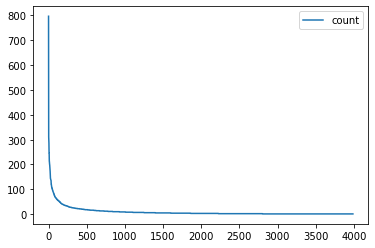

In [10]:
data = pd.DataFrame(pre_sheet(course_count)['count'])
data.plot()
# видим пик который мы и используем для нахождения минимальной границы

399


<AxesSubplot:>

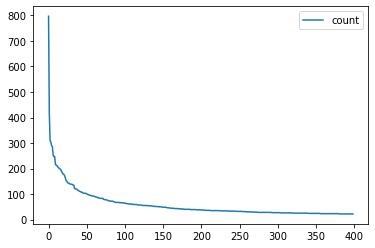

In [20]:
ten = int(round((len(pre_sheet(course_count))/100)*10,0))
print(str(ten))
data[:ten].plot()
# приблизительно с 10% процентов график начинает расти. Давайте считать что именно 90% квантиль
# и станет нашим значением для определения нижней границы, поле перехода которой для рекомендаций,
# будет проставлен самый популярный курс и второй за ним

In [12]:
bottom_line = int(pre_sheet(course_count)['count'].quantile(.90))
bottom_line # нижняя граница

22

In [14]:
def sheet(course_id_df,df,development = 0):
    
    '''
    Основная таблица 
    для переключения в режим тестирования или проверки 
    надо передать development = 1
    '''
    
    sheet_df =  pd.DataFrame(course_id_df.unique(),columns=['course'])
    
    h1 = [] # первый и второй столбец рекомендаций 
    h2 = []
    test1 = [] # собирают количество пар, по ним и подбираются рекомендации
    test2 = []
    # цикл для расставления всего по своим местам, ничего интересного
    for i in course_id_df.unique():
        way = df[(df['one']==i)|(df['two']==i)] # а ну тут что-то есть, список, 
        if way.iloc[0][0] == i:                   # который ищет текущие значение курса в обеих столбцах таблицы с количеством
            if way.iloc[1][2] > bottom_line:
                h1.append(way.iloc[0][1])
            else:
                h1.append(first_popular)
            test1.append(way.iloc[0][2])
            if way.iloc[1][0] == i:
                if way.iloc[1][2] > bottom_line:
                    h2.append(way.iloc[1][1])
                else:
                    if way.iloc[1][2] > bottom_line:
                        h2.append(first_popular)
                    else:
                        h2.append(second_popular)
                test2.append(way.iloc[1][2])
            else:
                if way.iloc[1][2] > bottom_line:
                    h2.append(way.iloc[1][0])
                else:
                    if way.iloc[1][2] > bottom_line:
                        h2.append(first_popular)
                    else:
                        h2.append(second_popular)
                test2.append(way.iloc[1][2])
        else:
            if way.iloc[0][2] > bottom_line:
                h1.append(way.iloc[0][0])
            else:
                h1.append(first_popular) 
            test1.append(way.iloc[0][2])
            if way.iloc[1][0] == i:
                if way.iloc[1][2] > bottom_line:
                    h2.append(way.iloc[1][1])
                else:
                    if way.iloc[0][2] > bottom_line:
                        h2.append(first_popular)
                    else:
                        h2.append(second_popular)
                test2.append(way.iloc[1][2])
            else:
                if way.iloc[1][2] > bottom_line:
                    h2.append(way.iloc[1][0])
                else:
                    if way.iloc[0][2] > bottom_line:
                        h2.append(first_popular)
                    else:
                        h2.append(second_popular)
                test2.append(way.iloc[1][2])
                
    if development == 1:    
        sheet_df['recommend_Nam1'] = h1
        sheet_df['test1'] = test1
        sheet_df['recommend_Nam2'] = h2
        sheet_df['test2'] = test2
        sheet_df.loc[126] = [last_course,first_popular,0,second_popular,0,] # последний ни одного раза не купленный курс
    else:
        sheet_df['recommend_Nam1'] = h1
        sheet_df['recommend_Nam2'] = h2
        sheet_df.loc[126] = [last_course,first_popular,second_popular,] # тоже самое но без пропусков для тест1 и тест2
    return sheet_df

### Таблица

In [15]:
final_sheet_df = sheet(course_count['course_id'],pre_sheet(course_count)) # вот таблица, 3 столбца

In [16]:
# для проверки соответствия рекомендаций по числам(количество той пры курсов, что взята для рекомендации) 
# вызовете эту же функцию с атрибутом "development = 1" пример ниже
# final_sheet_df = sheet(course_count['course_id'],pre_sheet(course_count),development = 1)

In [17]:
final_sheet_df.head(19)

,course,recommend_Nam1,recommend_Nam2
0,490,566,551
1,357,571,356
2,507,570,752
3,489,551,515
4,514,551,515
5,552,551,523
6,515,551,489
7,523,551,515
8,569,572,840
9,363,511,562


In [18]:
len(final_sheet_df)
final_sheet_df.tail(3)

,course,recommend_Nam1,recommend_Nam2
124,1160,551,566
125,1201,551,566
126,772,551,566


In [19]:
len(final_sheet_df) # полное количество

127

### Комментарий о выборе минимальной границы и более подходящего курса

Сначала краткий вывод 

Рекомендовать такой подбор курсов, может не сильно сказаться на среднем чеке онлайн-школы. Из-за того что у нас есть денные только по количеству покупок по id курсов, но нет необходимого уровня подготовки студента для курса (с нуля, мидл, 1.5 года опыта, тд…) и темы (аналитика, веб дизайн, фигурное вязание крючком...). Как без этих данных мы заранее точно скажем, что человеку купивший не очень популярный курс «Носки с рисунком за месяц», не предложит «Python для чайников, кофейников и других бытовых приборов». Нужно доработать. Но только после теста мы узнаем, насколько это будут правильно собранные рекомендации.

Теперь по выбору нижней границы. Я взял график и просто поискал интервал где он начинает рост, при большем увеличении масштаба начинают теряться более значимые пары значений. Может мнение и субъективно, зато наверняка не пострадают уникальные редкие пры курсов. Им как раз рекомендаций не хватало, скорей всего, и позже будут часто приобретаться как второй, третий и тд… курсы.

Предлагаемый курс за нижней границей. Тут всё не очень тяжело, в дата сете нет ничего о курсе кроме id. В работе представлен самый не сложный вариант, подставления 2‑х топ курсов. Можно встроить рандом в список, вместо двух самых популярных курсов, будет всплывать, при каждом переходе, курсы выше 98% квантиля (выше 73 повторяющихся пар). Но без риска, выдать вместо всем нравящихся вариантов, специфичные по тематике предложения, тут никуда. Также хороший, но нам неподошедшей, по причине отсутствия представителя онлайн-школы, передать топ курсов на проработку, чтобы из верхней 20ки человек подобрал может не топ 3, но те что реально круты и просто слегка отстали из-за того что школа опередила тренд, и например, после толчка в рекомендованные они могут стать новым бестселлером для сайта. Как вариант «Перевод всего офиса на удалёнку за неделю».